# URL-TITLE Classifier Analysis Notebook

This notebook extracts embeddings for a set of URL title categories, visualizes their relationships via heatmaps, t-SNE and UMAP, and uses HDBSCAN for clustering and further analysis.

In [12]:
#%pip install umap-learn hdbscan matplotlib seaborn pandas torch transformers numpy scikit-learn

## 1. Imports

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
import hdbscan
from scipy.spatial.distance import pdist, squareform

## 2. Model Setup

Load the pre-trained model and tokenizer.

In [14]:
# Load pre-trained model and tokenizer
model_path = "firefoxrecap/URL-TITLE-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

## 3. Embedding Extraction & Distance Heatmap

Define the URL title categories, extract their embeddings, and plot the cosine distance heatmap.

Embedding shape: (11, 768)


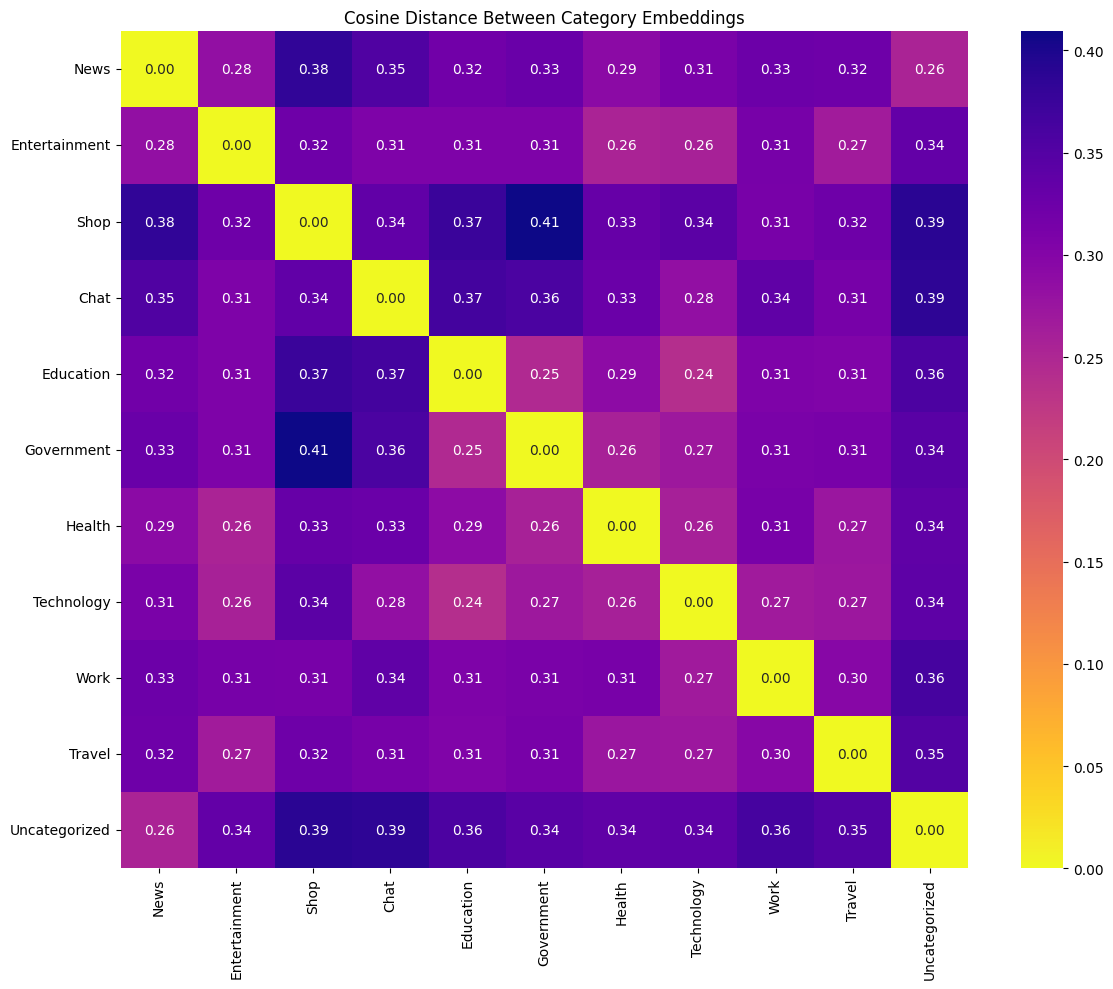

In [15]:
# Define the categories
labels = [
    "News", "Entertainment", "Shop", "Chat", "Education",
    "Government", "Health", "Technology", "Work", "Travel", "Uncategorized"
]

# Function to extract embeddings for a list of texts
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the CLS token output as the embedding
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# Extract embeddings for each category
category_embeddings = get_embeddings(labels)
print(f"Embedding shape: {category_embeddings.shape}")

# Compute pairwise cosine distances and create a heatmap
distances = pdist(category_embeddings, metric='cosine')
distance_matrix = squareform(distances)

plt.figure(figsize=(12, 10))
sns.heatmap(
    distance_matrix, 
    xticklabels=labels, 
    yticklabels=labels, 
    cmap='plasma_r',
    annot=True,
    fmt=".2f"
)
plt.title("Cosine Distance Between Category Embeddings")
plt.tight_layout()
plt.show()

## 4. Dimensionality Reduction

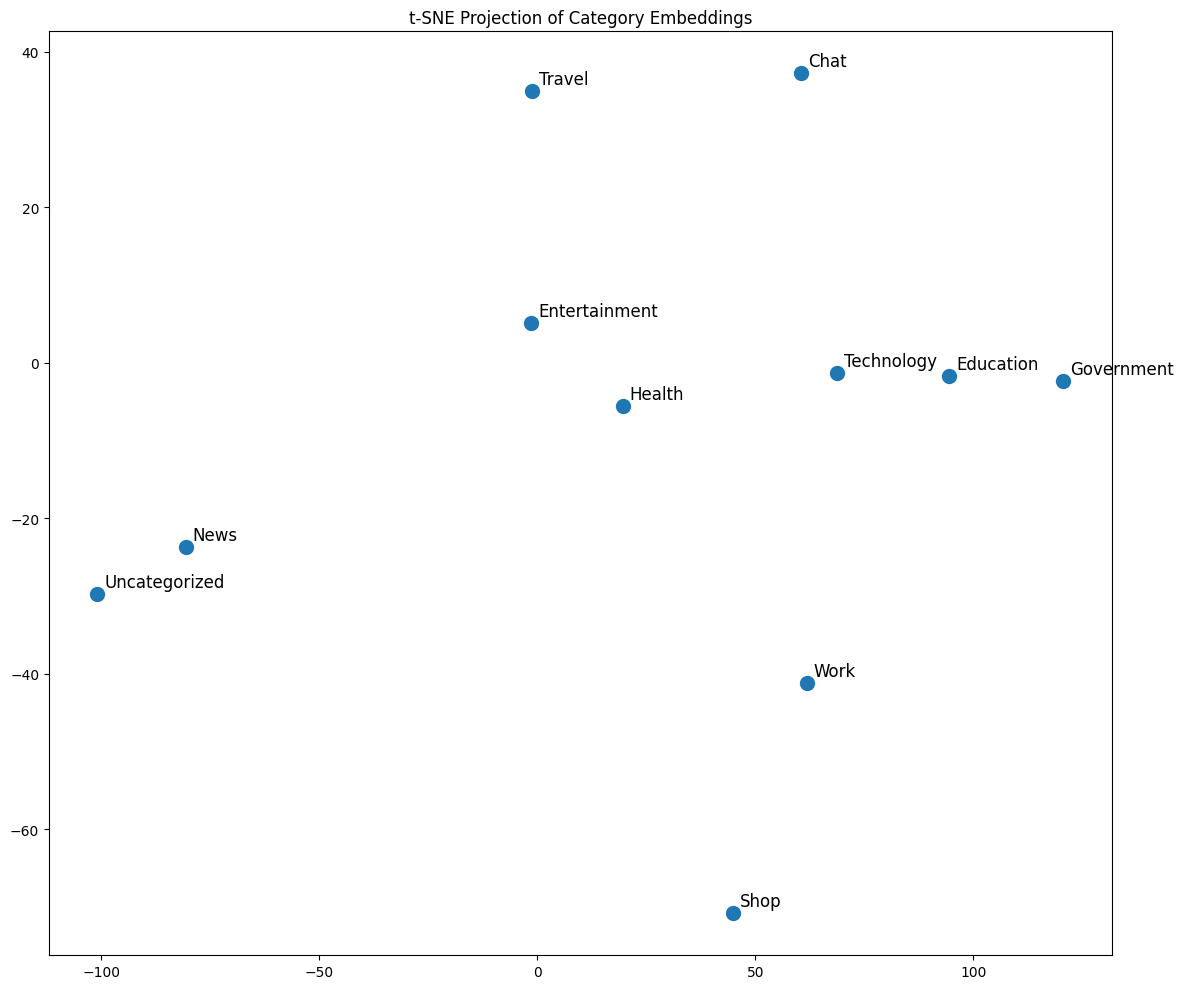

In [16]:
# t-SNE Projection
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
embeddings_2d = tsne.fit_transform(category_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12, xytext=(5, 5), textcoords='offset points')
plt.title("t-SNE Projection of Category Embeddings")
plt.tight_layout()
plt.show()

/Users/taimur/Library/Mobile Documents/com~apple~CloudDocs/Projects/url-title-classifer/url-title-classifier-testing/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/taimur/Library/Mobile Documents/com~apple~CloudDocs/Projects/url-title-classifer/url-title-classifier-testing/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


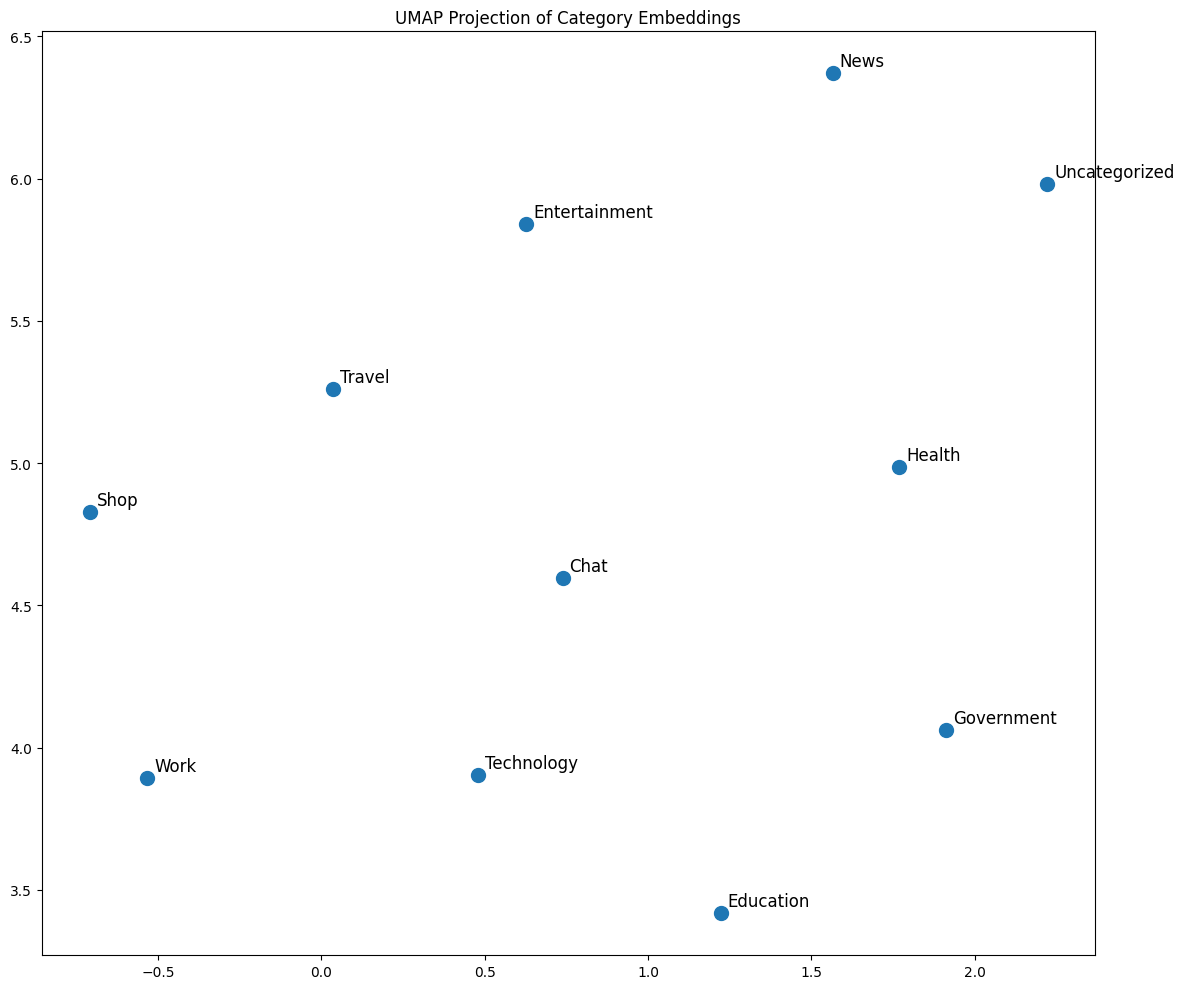

In [17]:
# UMAP Projection
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
umap_embeddings = reducer.fit_transform(category_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=100)
for i, label in enumerate(labels):
    plt.annotate(label, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=12, xytext=(5, 5), textcoords='offset points')
plt.title("UMAP Projection of Category Embeddings")
plt.tight_layout()
plt.show()

## 5. Clustering with HDBSCAN

/Users/taimur/Library/Mobile Documents/com~apple~CloudDocs/Projects/url-title-classifer/url-title-classifier-testing/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/taimur/Library/Mobile Documents/com~apple~CloudDocs/Projects/url-title-classifer/url-title-classifier-testing/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


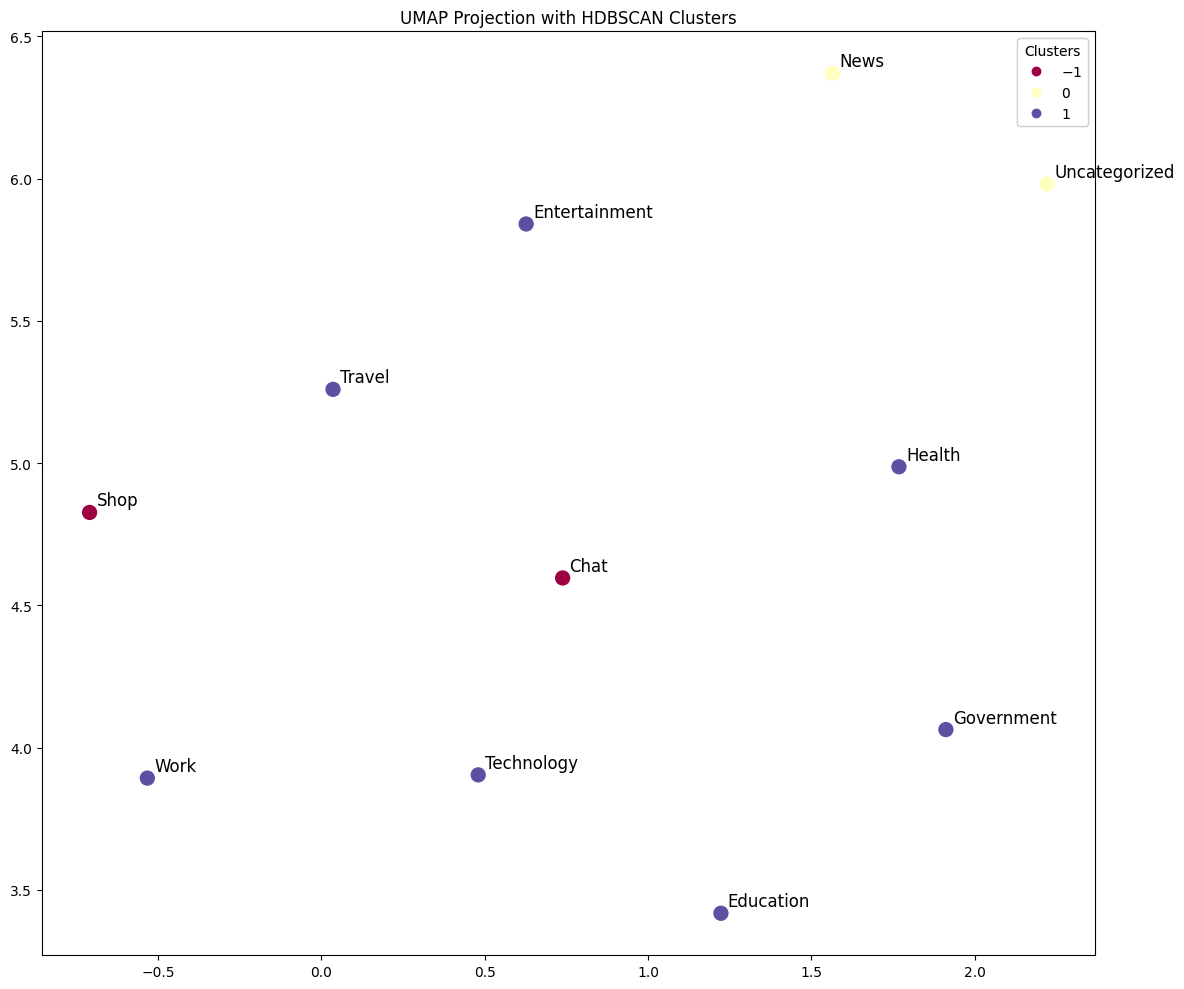

In [18]:
# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
cluster_labels = clusterer.fit_predict(category_embeddings)

# Visualize UMAP projection with cluster labels
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='Spectral', s=100)
for i, label in enumerate(labels):
    plt.annotate(label, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=12, xytext=(5, 5), textcoords='offset points')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.tight_layout()
plt.show()

## 6. Cluster Analysis: Centroids & Silhouette Score

In [19]:
# Calculate centroids (mean embedding per cluster) excluding noise (-1)
centroids = {}
unique_clusters = sorted(list(set(cluster_labels)))
if -1 in unique_clusters:
    unique_clusters.remove(-1)  # Exclude noise

for cluster_id in unique_clusters:
    cluster_mask = (cluster_labels == cluster_id)
    centroids[cluster_id] = category_embeddings[cluster_mask].mean(axis=0)

# If there are multiple clusters, compute pairwise distances between centroids
if len(centroids) > 1:
    centroid_embeddings = np.array(list(centroids.values()))
    centroid_labels = [f"Cluster {cid}" for cid in centroids.keys()]
    centroid_distances = pdist(centroid_embeddings, metric='cosine')
    centroid_distance_matrix = squareform(centroid_distances)
    
    print("\nDistances between Cluster Centroids:")
    print(pd.DataFrame(centroid_distance_matrix, index=centroid_labels, columns=centroid_labels))

# Compute silhouette score (excluding noise)
core_samples_mask = cluster_labels != -1
if len(set(cluster_labels[core_samples_mask])) > 1:
    silhouette_avg = silhouette_score(category_embeddings[core_samples_mask], cluster_labels[core_samples_mask], metric='cosine')
    print(f"\nSilhouette Score (excluding noise): {silhouette_avg:.4f}")
else:
    print("\nNot enough clusters (excluding noise) to calculate Silhouette Score.")


Distances between Cluster Centroids:
           Cluster 0  Cluster 1
Cluster 0   0.000000   0.175533
Cluster 1   0.175533   0.000000

Silhouette Score (excluding noise): 0.1602


## 7. Additional Analysis

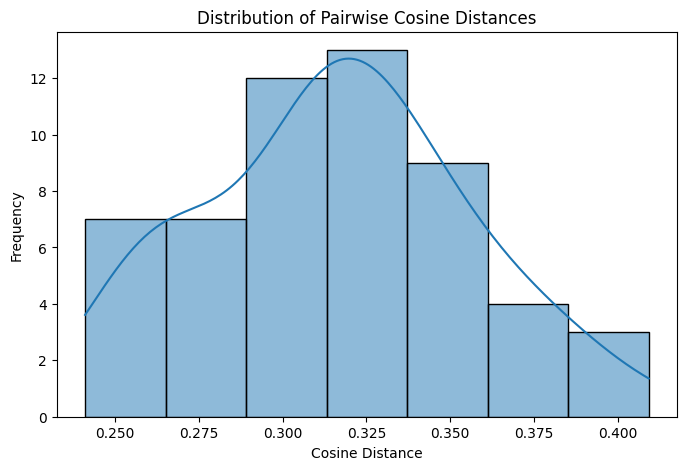

In [20]:
# Plot distribution of pairwise cosine distances
plt.figure(figsize=(8, 5))
sns.histplot(distances, kde=True)
plt.title('Distribution of Pairwise Cosine Distances')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Find nearest and farthest neighbors for each category
n_neighbors = 3
print("\nNearest and Farthest Neighbors:")
for i, label in enumerate(labels):
    dists = distance_matrix[i, :]
    sorted_indices = np.argsort(dists)[1:]
    nearest = [labels[j] for j in sorted_indices[:n_neighbors]]
    farthest = [labels[j] for j in sorted_indices[-n_neighbors:]]
    print(f"- {label}:")
    print(f"  Nearest {n_neighbors}: {', '.join(nearest)}")
    print(f"  Farthest {n_neighbors}: {', '.join(farthest[::-1])}")


Nearest and Farthest Neighbors:
- News:
  Nearest 3: Uncategorized, Entertainment, Health
  Farthest 3: Shop, Chat, Government
- Entertainment:
  Nearest 3: Health, Technology, Travel
  Farthest 3: Uncategorized, Shop, Work
- Shop:
  Nearest 3: Work, Travel, Entertainment
  Farthest 3: Government, Uncategorized, News
- Chat:
  Nearest 3: Technology, Entertainment, Travel
  Farthest 3: Uncategorized, Education, Government
- Education:
  Nearest 3: Technology, Government, Health
  Farthest 3: Shop, Chat, Uncategorized
- Government:
  Nearest 3: Education, Health, Technology
  Farthest 3: Shop, Chat, Uncategorized
- Health:
  Nearest 3: Entertainment, Government, Technology
  Farthest 3: Uncategorized, Shop, Chat
- Technology:
  Nearest 3: Education, Entertainment, Health
  Farthest 3: Shop, Uncategorized, News
- Work:
  Nearest 3: Technology, Travel, Education
  Farthest 3: Uncategorized, Chat, News
- Travel:
  Nearest 3: Entertainment, Technology, Health
  Farthest 3: Uncategorized, Ne

In [22]:
# Function to find the most similar and most different category pairs
def find_similar_different_pairs(distance_matrix, labels):
    min_dist = np.inf
    min_pair = None
    max_dist = -np.inf
    max_pair = None
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            if distance_matrix[i, j] < min_dist:
                min_dist = distance_matrix[i, j]
                min_pair = (labels[i], labels[j])
            if distance_matrix[i, j] > max_dist:
                max_dist = distance_matrix[i, j]
                max_pair = (labels[i], labels[j])
    return min_pair, min_dist, max_pair, max_dist

min_pair, min_dist, max_pair, max_dist = find_similar_different_pairs(distance_matrix, labels)
print(f"Most similar categories: {min_pair[0]} and {min_pair[1]} (distance: {min_dist:.4f})")
print(f"Most different categories: {max_pair[0]} and {max_pair[1]} (distance: {max_dist:.4f})")

# Analyze HDBSCAN clusters
if len(set(cluster_labels)) > 1:
    clusters = {}
    for i, cluster_id in enumerate(cluster_labels):
        cluster_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
        clusters.setdefault(cluster_name, []).append(labels[i])
    
    print("\nHDBSCAN Clusters:")
    for cluster_name, members in clusters.items():
        print(f"{cluster_name}: {', '.join(members)}")

Most similar categories: Education and Technology (distance: 0.2411)
Most different categories: Shop and Government (distance: 0.4093)

HDBSCAN Clusters:
Cluster 0: News, Uncategorized
Cluster 1: Entertainment, Education, Government, Health, Technology, Work, Travel
Noise: Shop, Chat
